
# Implementing Global Sensitivity Analysis for Different Cases of the Macrophage Tumor Population Model
## Tumor Volume is the Outcome of Interest for All Cases

### The first three cases represent a parameter set with low tumor volume (Case 1), a parameter set which produces bistability (Case 2), and a parameter set which yields a high tumor volume (Case 3)


### We also explore a variety of other cases.  The six most sensitive parameters of each case are summarized here.  (Code below was used to produce this analysis.)

$$
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{Case 1 (L)} & \textbf{Case 2 (B)} & \textbf{Case 3 (H)} & \textbf{Case 4 (B)} & \textbf{Case 5 (B)} & \textbf{Case 6 (H)} & \textbf{Case 7 (B)} & \textbf{Case 8 (B)} & \textbf{Case 9 (H)} \\
\hline
r_1 & r_1 & p_T & r_1 & r_1 & r_2 & r_1 & r_1 & r_2 \\
\alpha_{01} & d_T & d_T & \alpha_{02} & \alpha_{02} & \alpha_{02} & \alpha_{02} & d_2 & \alpha_{12} \\
d_2 & d_2 & r_2 & d_1 & d_1 & d_1 & d_1 & r_2 & d_2 \\
d_1 & \alpha_{1m} & d_2 & \alpha_{01} & \alpha_{01} & r_1 & \alpha_{01} & \alpha_{12} & d_T \\
\alpha_{02} & \beta & \beta & r_2 & d_2 & \alpha_{01} & d_2 & \beta & p_T \\
K & p_T & K & d_T & r_2 & d_2 & r_2 & d_T & r_1 \\
\hline
\end{array}
$$

### Define System of ODEs

Our state variables are $T$, tumor volume, $M_0$, naive macrophages, $M_1$,  M1-like macrophages, $M_2$, M2-like macrophages, and $M_m$, mixed (or $M_1/M_2$) phenotype macrophages.


Model Equations (see Overleaf document for pathways and justification):

$\frac{dT}{dt}={p_T \cdot T \cdot \left(1-T\right)(1 -r_1M_1+ r_2M_2 )} - {d_T T}$
$\frac{dM_0}{dt}={p_{0}T\left(1-\frac{M_0+M_1+M_2+M_m}{K}\right)\left(1+\gamma M_1\right)} - \left({d_{0}} + {\alpha_{01}} + {\alpha_{02} \left(1+\frac{\beta T}{T+f}\right)}\right)M_0 + {\alpha_{10}M_1} + {\alpha_{20}M_2}$
$ \frac{dM_1}{dt}= -\left({d_{1}} + {\alpha_{10}}  + {\alpha_{12} \left(1+ \frac{\beta T}{T+f}\right)} + {\alpha_{1m}  \left(1+ \frac{\beta T}{T+f}\right)}\right)M_1 + {\alpha_{01}M_0} +{\alpha_{21}M_2}  + {\alpha_{m1}M_m}$
$\frac{dM_2}{dt}= -\left({d_{2}} +{\alpha_{20}} + {\alpha_{21}} + {\alpha_{2m}} \right)M_2+ \left({\alpha_{02}M_0 } + {\alpha_{12}M_1 } + {\alpha_{m2}M_m  }\right)\cdot \left(1+ \frac{\beta T}{T+f}\right)$
$\frac{dM_m}{dt}= -\left({d_{m}} + {\alpha_{m1}} + {\alpha_{m2} \left(1+ \frac{\beta T}{T+f}\right)}\right)M_m + {\alpha_{1m}\left(1+\frac{\beta T}{T+ f}\right)M_1}+ {\alpha_{2m}M_2 }$

Note, this system has 23 parameters which will be explored. 



Install libraries.  Note: If working on a computer without SALib installed, type conda install SALib in terminal before importing modules.

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
from SALib.sample import saltelli
from SALib.analyze import sobol

0.015501737594604492


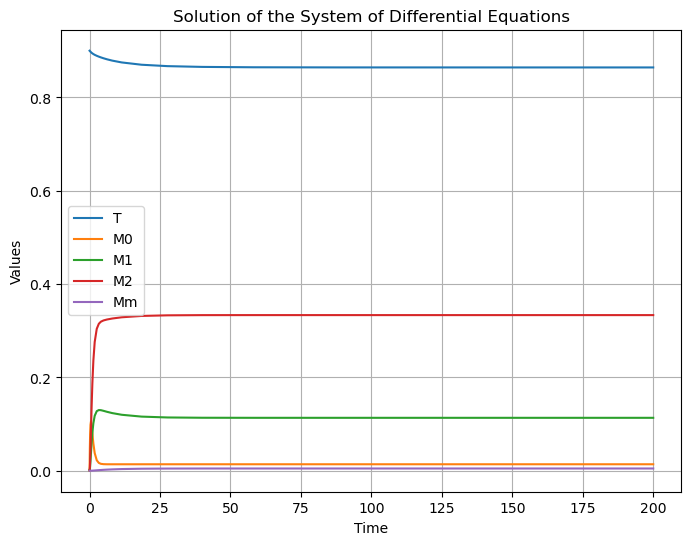

In [4]:
# Define the system of differential equations
# this modification eliminates h from first equation
# this version adjusts basline values for r1, r2, pT to compensate for rescaling to remove h

def equations(t, y, pT, f, dT, r1, r2, p0, g, d0, alpha01, alpha02, alpha10, alpha20, b, d1, alpha1m, d2, 
              alpham2, dm, alpham1,alpha2m, alpha12, alpha21, K):
    T, M0, M1, M2, Mm = y

    f0 = pT * T * (1 - T) * (1 - r1 * M1 + r2 * M2) - dT * T
    f1 = (p0 * T * (1 - (M0 + M1 + M2 + Mm) / K) * (1 + g * M1) +
          alpha10 * M1 + alpha20 * M2 -
          d0 * M0 - alpha01 * M0 -
          alpha02 * M0 * (1 + b * T / (T + f)))
    f2 = (-d1 * M1 - alpha10 * M1 +
          alpha01 * M0 + alpha21 * M2 + alpham1 * Mm -
          (alpha12 * M1 + alpha1m * M1) * (1 + b * T / (T + f)))
    f3 = (-d2 * M2 - alpha20 * M2 - alpha21 * M2 - alpha2m * M2 +
          (alpha02 * M0 + alpha12 * M1 + alpham2 * Mm) * (1 + b * T / (T + f)))
    f4 = (-dm * Mm - alpham1 * Mm + alpha2m * M2 +
          (alpha1m * M1 - alpham2 * Mm) * (1 + b * T / (T + f)))

    return [f0, f1, f2, f3, f4]

# Define the time span
t_span = (0, 200)  # Define the start and end time

# Define initial conditions [T0, M0_0, M1_0, M2_0, Mm_0]
T0 = .9  # initial tumor burden (scaled volume)
M00 = .0003  # initial M0
M10 = .001  # initial M1
M20 = .001  # initial M2
Mm0 = 0  # initial Mm
initial_conditions = [T0, M00, M10, M20, Mm0]


#  baseline parameter value from Table 3 in Overleaf 3/4/2025

pT_val = .023 # rescaled
p0_val = .7
K_val = .5
f_val = .5
g_val = 1
r1_val = 10 # rescaled
r2_val = 10 # rescaled
dT_val = .01
d0_val = .1
d1_val = .1
d2_val = .1
dm_val = .1

alpha01_val = 1
alpha02_val = 1
alpha10_val = .0001
alpha12_val = .01
alpha1m_val = .001
alpha20_val = .0001
alpha21_val = .001
alpha2m_val = .001
alpham1_val = .001
alpham2_val = .01

b_val = 2



# Define parameters
params = (pT_val, f_val, dT_val, r1_val, r2_val, p0_val, g_val, d0_val, alpha01_val,
          alpha02_val, alpha10_val, alpha20_val, b_val, d1_val, alpha1m_val, d2_val, alpham2_val, dm_val, alpham1_val,
         alpha2m_val, alpha12_val, alpha21_val, K_val)

start = time.time() # time process

# Solve the system of differential equations with parameters
sol = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')

end = time.time()
print(end-start)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y.T)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the System of Differential Equations')
plt.legend(['T', 'M0', 'M1', 'M2', 'Mm'])
plt.grid(True)
plt.show()

# Implement GSA

## Case 1 (Low)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_112/3136168194.py:72: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


21912.922709941864


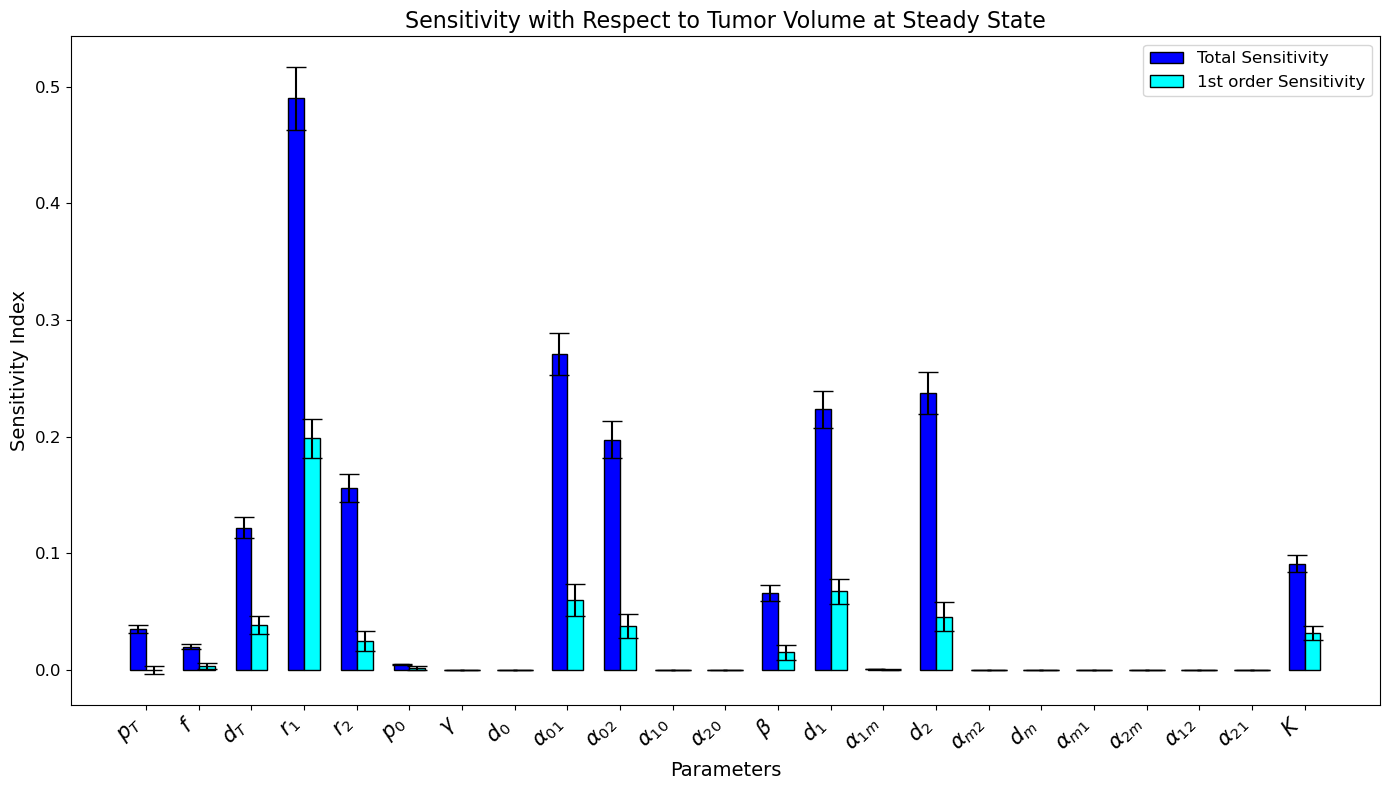

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from SALib.sample import saltelli
from SALib.analyze import sobol
import time

#  baseline parameter value from Table 3 in Overleaf 5/17/2025

# these are fixed across cases
pT = .023 
p0 = .7
K = .5
f = .5
g = 1
r1 = 10 
r2 = 10 
dT = .01
d0 = .1
d1 = .1
d2 = .1
dm = .1

alpha10 = .0001  
#alpha12 = .01
alpha21 = .001
alpha2m = .001
alpham1 = .001
alpham2 = .01

b = 2

# case 1 values for alphas from Table 4 in Overleaf (these vary by cases)

alpha02 = .1
alpha1m = .001
alpha01 = 1
alpha20 = .0001
alpha12 = 1e-8 # small nonzero placeholder to ensure valid bounds

# Define parameter problem and bounds
problem = {
    'num_vars': 23, # remove h so there are 23 parameters
    'names': ['pT', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],    
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0.5*alpham1, 1.5*alpham1], 
               [0.5*alpha2m, 1.5*alpha2m], 
               [0.5*alpha12, 1.5*alpha12], # force interval
               [0.5*alpha21, 1.5*alpha21], 
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 
Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8))  # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels and larger fonts
plt.xticks([r + barWidth/2 for r in range(len(ST_values))],
           [r'$p_T$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$\gamma$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$\beta$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], 
           rotation=45, ha='right', fontsize=15) # control font size here

plt.ylabel(r'Sensitivity Index', fontsize=14)
plt.xlabel('Parameters', fontsize=14)
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()

# Save and show the plot
f.savefig("GSA-Case1-TumorVolume-2025May.pdf", bbox_inches='tight', dpi=300)
plt.show()



### Case 2 (Bistability)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_112/29595745.py:64: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


11079.662340164185


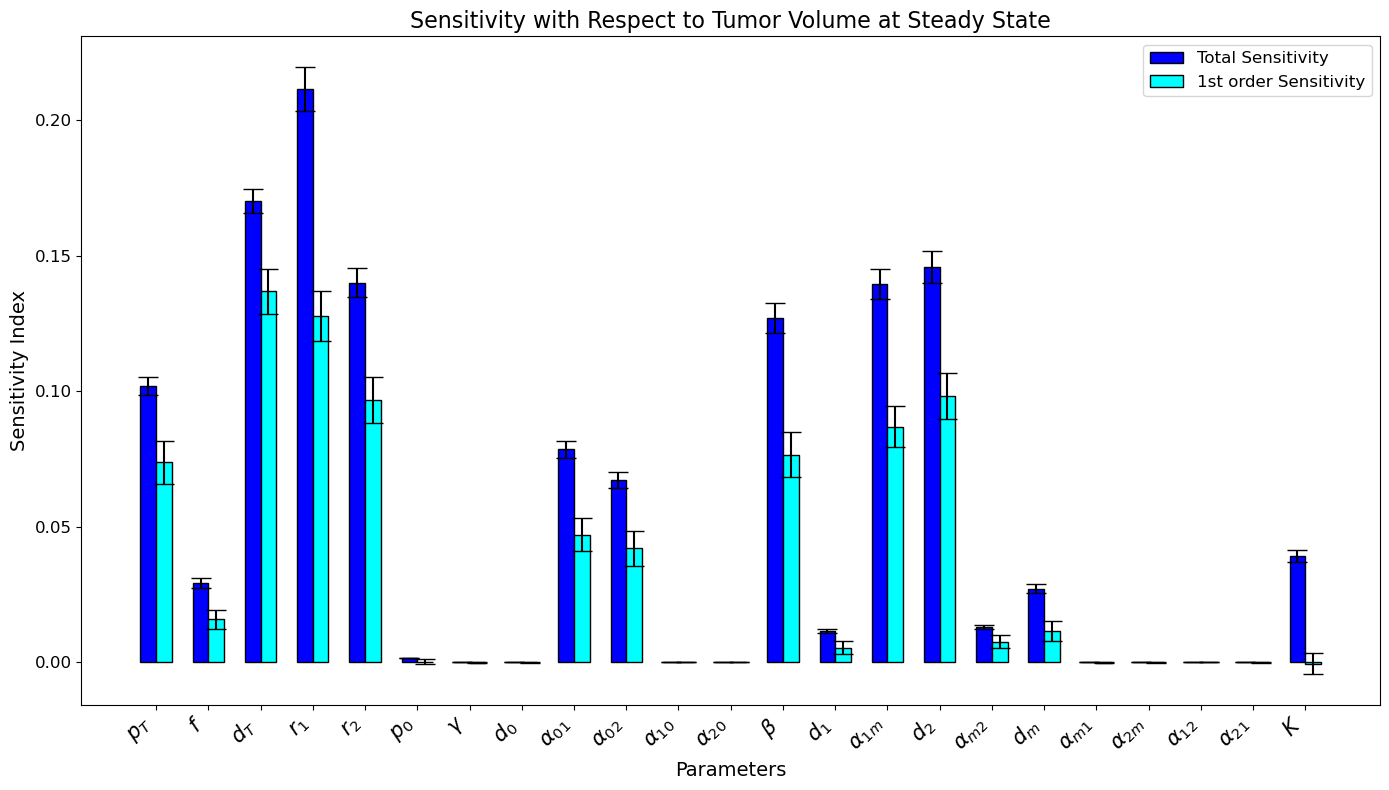

In [4]:

# these are fixed across cases
pT = .023 # rescaled
p0 = .7
K = .5
f = .5
g = 1
r1 = 10 # rescaled
r2 = 10 # rescaled
dT = .01
d0 = .1
d1 = .1
d2 = .1
dm = .1

alpha10 = .0001

alpha21 = .001
alpha2m = .001
alpham1 = .001
alpham2 = .01

b = 2

# case 2 values for alphas from Table 4 in Overleaf (these vary by cases)

alpha02 = .1
alpha1m = .1
alpha01 = 1
alpha20 = .0001
alpha12 = 1e-8 # small nonzero placeholder to ensure valid bounds


# Define parameter problem and bounds
problem = {
    'num_vars': 23, # remove h so there are 23 parameters
    'names': ['pT', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],    
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0.5*alpham1, 1.5*alpham1], 
               [0.5*alpha2m, 1.5*alpha2m], 
               [0.5*alpha12, 1.5*alpha12], 
               [0.5*alpha21, 1.5*alpha21], 
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()


# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8))  # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels and larger fonts
plt.xticks([r + barWidth/2 for r in range(len(ST_values))],
           [r'$p_T$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$\gamma$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$\beta$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], 
           rotation=45, ha='right', fontsize=15) # control font size here

plt.ylabel(r'Sensitivity Index', fontsize=14)
plt.xlabel('Parameters', fontsize=14)
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()

# Save and show the plot
f.savefig("GSA-Case2-TumorVolume-2025May.pdf", bbox_inches='tight', dpi=300)
plt.show()







### Case 3 (High Tumor Volume)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_112/2702119482.py:66: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


3433.6997492313385


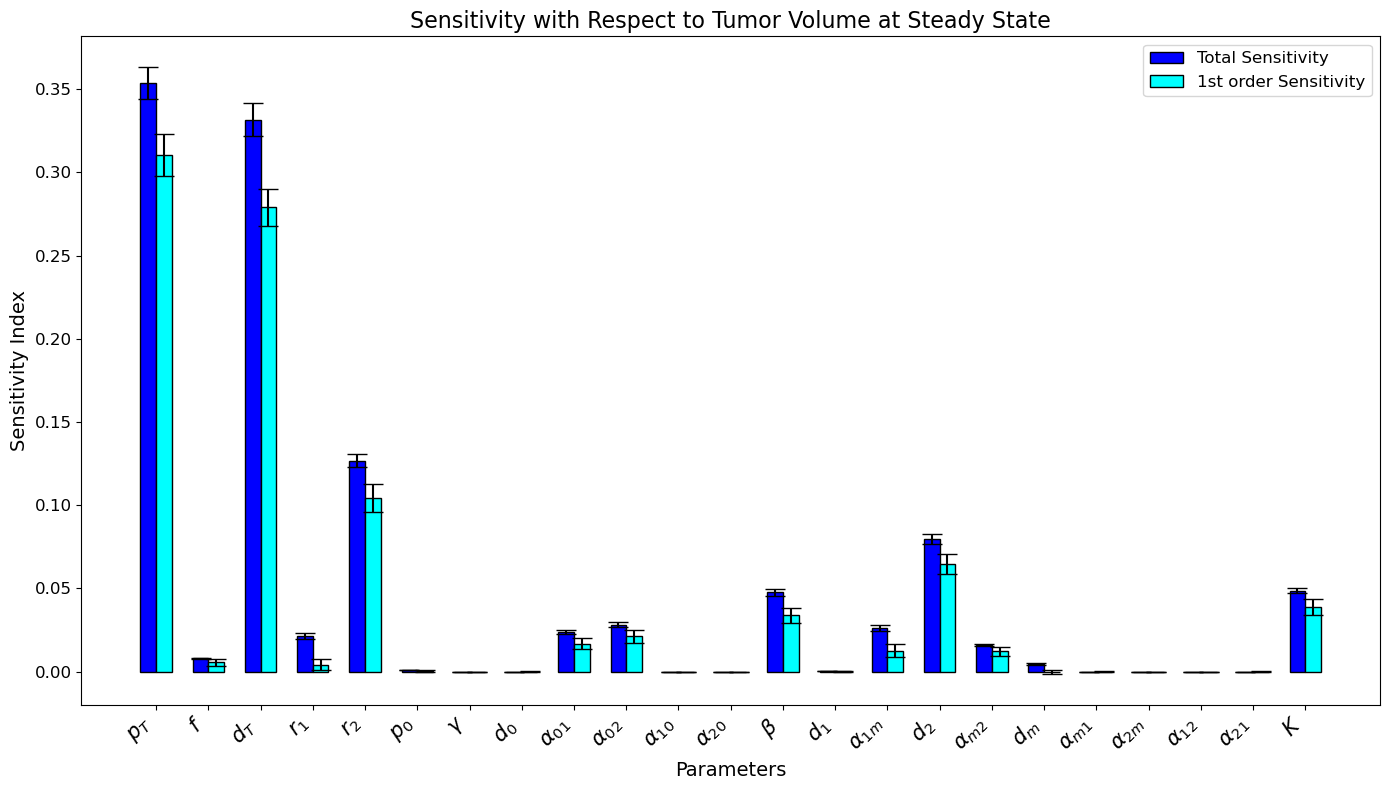

In [5]:

# these are fixed across cases
pT = .023 # rescaled
p0 = .7
K = .5
f = .5
g = 1
r1 = 10 # rescaled
r2 = 10 # rescaled
dT = .01
d0 = .1
d1 = .1
d2 = .1
dm = .1

alpha10 = .0001
alpha12 = .01
alpha21 = .001
alpha2m = .001
alpham1 = .001
alpham2 = .01

b = 2

# case 3 values for alphas from Table 4 in Overleaf (these vary by cases)

alpha02 = .1
alpha1m = .5
alpha01 = 1
alpha20 = .0001
alpha12 = 1e-8 # small nonzero placeholder to ensure valid bounds


# Define parameter problem and bounds
problem = {
    'num_vars': 23, # remove h so there are 23 parameters
    'names': ['pT', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],    
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0.5*alpham1, 1.5*alpham1], 
               [0.5*alpha2m, 1.5*alpha2m], 
               [0.5*alpha12, 1.5*alpha12], 
               [0.5*alpha21, 1.5*alpha21], 
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

########################

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8))  # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels and larger fonts
plt.xticks([r + barWidth/2 for r in range(len(ST_values))],
           [r'$p_T$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$\gamma$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$\beta$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], 
           rotation=45, ha='right', fontsize=15) # control font size here

plt.ylabel(r'Sensitivity Index', fontsize=14)
plt.xlabel('Parameters', fontsize=14)
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()

# Save and show the plot
f.savefig("GSA-Case3-TumorVolume-2025May.pdf", bbox_inches='tight', dpi=300)
plt.show()



### Case 4 Bistable

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_112/4291520096.py:64: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


45856.41219806671


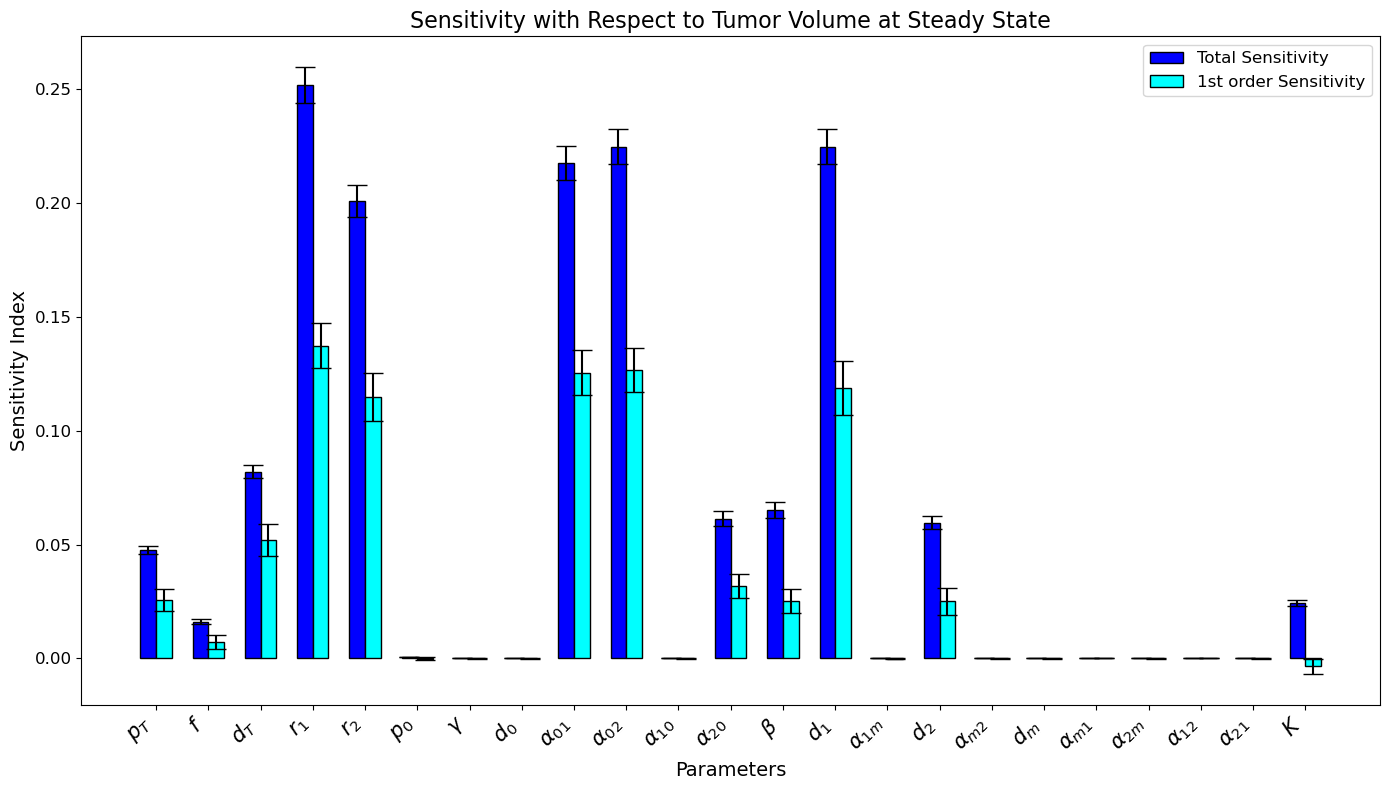

In [6]:

# these are fixed across cases
pT = .023 # rescaled
p0 = .7
K = .5
f = .5
g = 1
r1 = 10 # rescaled
r2 = 10 # rescaled
dT = .01
d0 = .1
d1 = .1
d2 = .1
dm = .1

alpha10 = .0001
alpha21 = .001
alpha2m = .001
alpham1 = .001
alpham2 = .01

b = 2

# case 4 values for alphas from Table 4 in Overleaf (these vary by cases)

alpha02 = 1
alpha1m = .001
alpha01 = 1
alpha20 = .1
alpha12 = 1e-8 # small nonzero placeholder to ensure valid bounds



# Define parameter problem and bounds
problem = {
    'num_vars': 23, # remove h so there are 23 parameters
    'names': ['pT', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],    
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0.5*alpham1, 1.5*alpham1], 
               [0.5*alpha2m, 1.5*alpha2m], 
               [0.5*alpha12, 1.5*alpha12], 
               [0.5*alpha21, 1.5*alpha21], 
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8))  # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels and larger fonts
plt.xticks([r + barWidth/2 for r in range(len(ST_values))],
           [r'$p_T$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$\gamma$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$\beta$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], 
           rotation=45, ha='right', fontsize=15) # control font size here

plt.ylabel(r'Sensitivity Index', fontsize=14)
plt.xlabel('Parameters', fontsize=14)
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()

# Save and show the plot
f.savefig("GSA-Case4-TumorVolume-2025May.pdf", bbox_inches='tight', dpi=300)
plt.show()




### Case 5 (bistable)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_112/2008475510.py:65: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


5450.597637176514


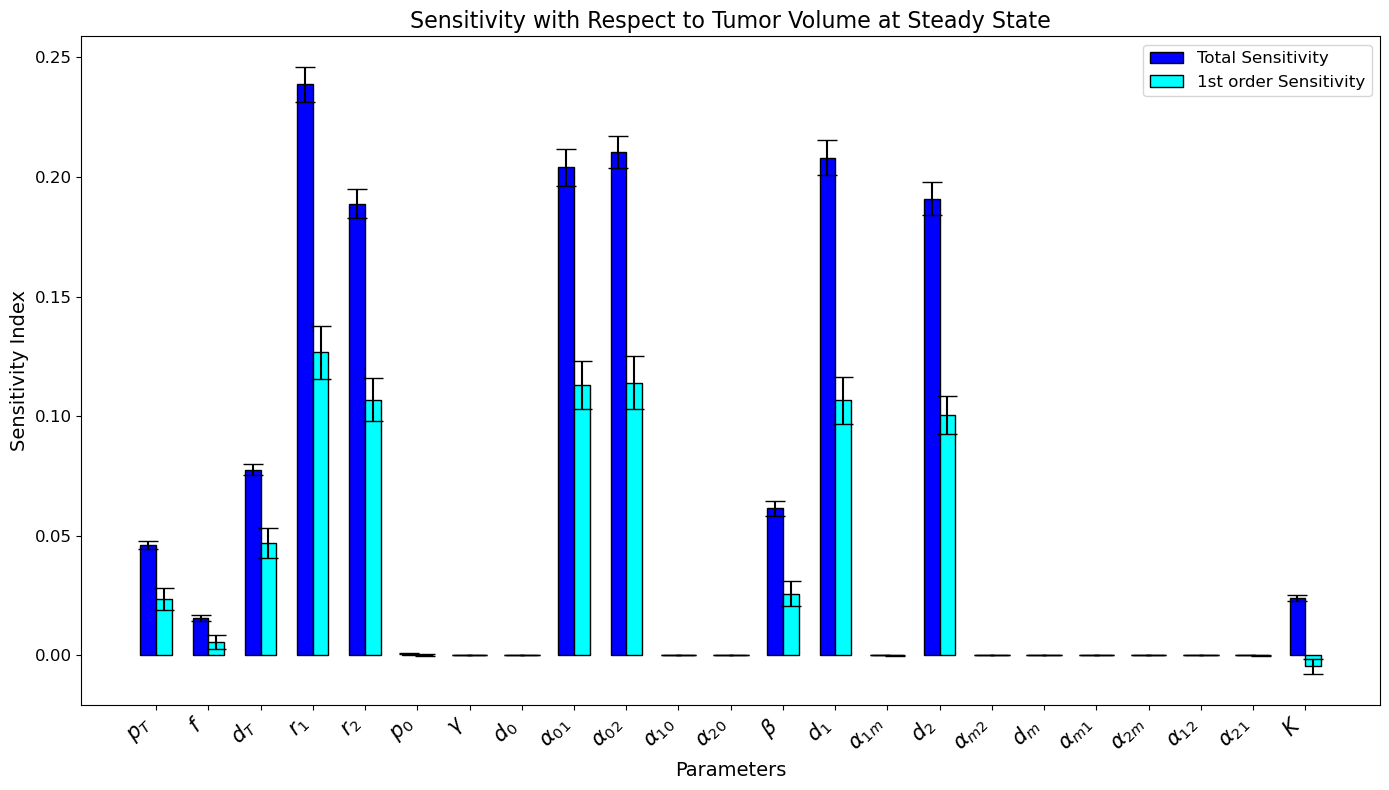

In [7]:

# these are fixed across cases
pT = .023 # rescaled
p0 = .7
K = .5
f = .5
g = 1
r1 = 10 # rescaled
r2 = 10 # rescaled
dT = .01
d0 = .1
d1 = .1
d2 = .1
dm = .1

alpha10 = .0001
alpha12 = .01
alpha21 = .001
alpha2m = .001
alpham1 = .001
alpham2 = .01

b = 2

# case 5 values for alphas from Table 4 in Overleaf (these vary by cases)

alpha02 = .5
alpha1m = .001
alpha01 = 1
alpha20 = .0001
alpha12 = 1e-8 # small nonzero placeholder to ensure valid bounds



# Define parameter problem and bounds
problem = {
    'num_vars': 23, # remove h so there are 23 parameters
    'names': ['pT', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],    
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0.5*alpham1, 1.5*alpham1], 
               [0.5*alpha2m, 1.5*alpha2m], 
               [0.5*alpha12, 1.5*alpha12], 
               [0.5*alpha21, 1.5*alpha21], 
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8))  # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels and larger fonts
plt.xticks([r + barWidth/2 for r in range(len(ST_values))],
           [r'$p_T$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$\gamma$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$\beta$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], 
           rotation=45, ha='right', fontsize=15) # control font size here

plt.ylabel(r'Sensitivity Index', fontsize=14)
plt.xlabel('Parameters', fontsize=14)
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()

# Save and show the plot
f.savefig("GSA-Case5-TumorVolume-2025May.pdf", bbox_inches='tight', dpi=300)
plt.show()


### Case 6 (high)

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_112/1878768941.py:64: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


11425.355622053146


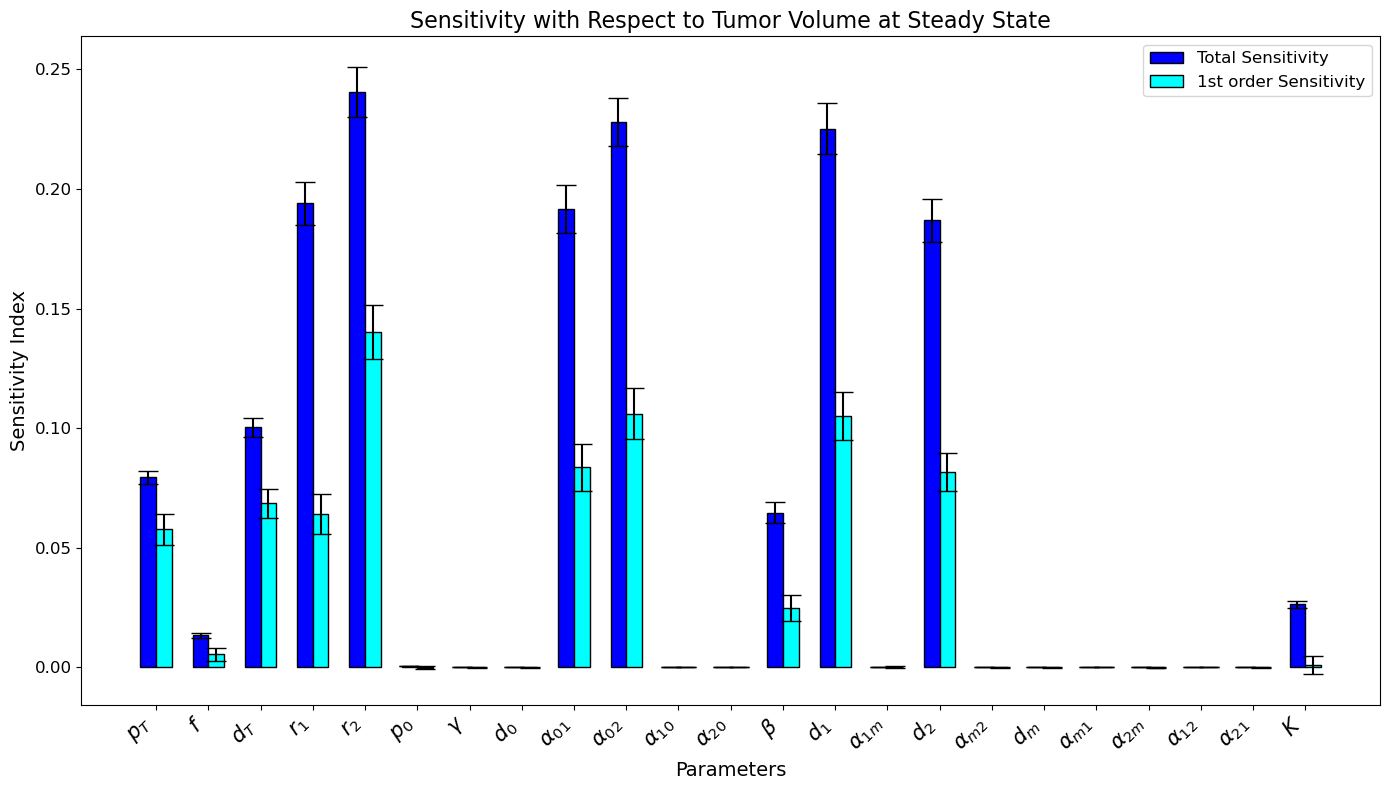

In [8]:

# these are fixed across cases
pT = .023 # rescaled
p0 = .7
K = .5
f = .5
g = 1
r1 = 10 # rescaled
r2 = 10 # rescaled
dT = .01
d0 = .1
d1 = .1
d2 = .1
dm = .1

alpha10 = .0001
alpha12 = .01
alpha21 = .001
alpha2m = .001
alpham1 = .001
alpham2 = .01

b = 2

# case 6 values for alphas from Table 4 in Overleaf (these vary by cases)

alpha02 = 1
alpha1m = .001
alpha01 = 1
alpha20 = .0001
alpha12 = 1e-8 # small nonzero placeholder to ensure valid bounds


# Define parameter problem and bounds
problem = {
    'num_vars': 23, # remove h so there are 23 parameters
    'names': ['pT', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],    
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0.5*alpham1, 1.5*alpham1], 
               [0.5*alpha2m, 1.5*alpha2m], 
               [0.5*alpha12, 1.5*alpha12], 
               [0.5*alpha21, 1.5*alpha21], 
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8))  # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels and larger fonts
plt.xticks([r + barWidth/2 for r in range(len(ST_values))],
           [r'$p_T$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$\gamma$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$\beta$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], 
           rotation=45, ha='right', fontsize=15) # control font size here

plt.ylabel(r'Sensitivity Index', fontsize=14)
plt.xlabel('Parameters', fontsize=14)
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()

# Save and show the plot
f.savefig("GSA-Case6-TumorVolume-2025May.pdf", bbox_inches='tight', dpi=300)
plt.show()


## Case 7 Bistable

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_1719/4202969872.py:64: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


30618.249557971954


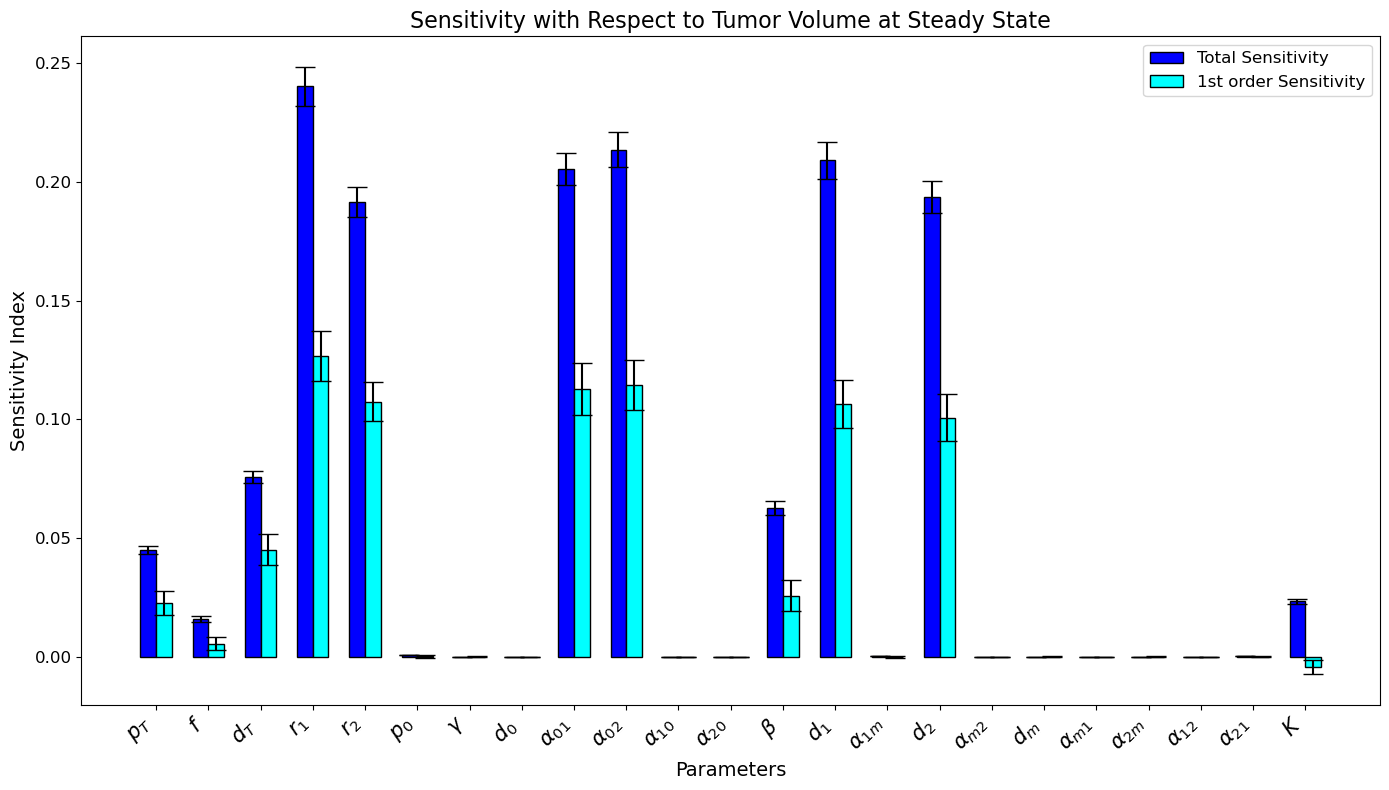

In [5]:
# these are fixed across cases
pT = .023 # rescaled
p0 = .7
K = .5
f = .5
g = 1
r1 = 10 # rescaled
r2 = 10 # rescaled
dT = .01
d0 = .1
d1 = .1
d2 = .1
dm = .1

alpha10 = .0001
alpha12 = .01
alpha21 = .001
alpha2m = .001
alpham1 = .001
alpham2 = .01

b = 2

# case 7 values for alphas from Table 4 in Overleaf as of May 20 (these vary by cases)

alpha02 = 1
alpha1m = .001
alpha01 = 2
alpha20 = .0001
alpha12 = 1e-8 # small nonzero placeholder to ensure valid bounds


# Define parameter problem and bounds
problem = {
    'num_vars': 23, # remove h so there are 23 parameters
    'names': ['pT', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],    
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0.5*alpham1, 1.5*alpham1], 
               [0.5*alpha2m, 1.5*alpha2m], 
               [0.5*alpha12, 1.5*alpha12], 
               [0.5*alpha21, 1.5*alpha21], 
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8))  # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels and larger fonts
plt.xticks([r + barWidth/2 for r in range(len(ST_values))],
           [r'$p_T$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$\gamma$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$\beta$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], 
           rotation=45, ha='right', fontsize=15) # control font size here

plt.ylabel(r'Sensitivity Index', fontsize=14)
plt.xlabel('Parameters', fontsize=14)
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()

# Save and show the plot
f.savefig("GSA-Case7-TumorVolume-2025May.pdf", bbox_inches='tight', dpi=300)
plt.show()


### Case 8 Bistable

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_112/3773373797.py:64: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


3484.1945540905


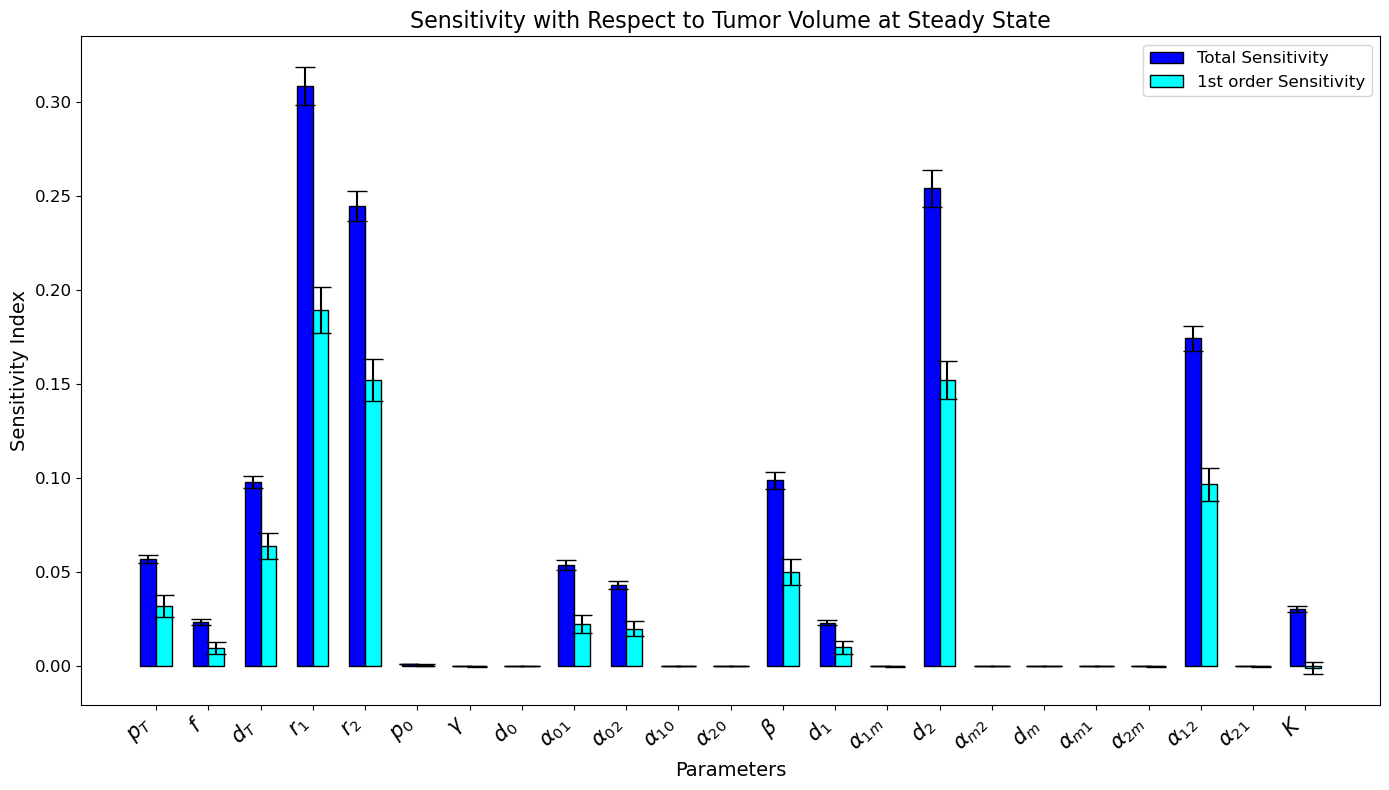

In [10]:
# these are fixed across cases
pT = .023 # rescaled
p0 = .7
K = .5
f = .5
g = 1
r1 = 10 # rescaled
r2 = 10 # rescaled
dT = .01
d0 = .1
d1 = .1
d2 = .1
dm = .1

alpha10 = .0001
alpha12 = .01
alpha21 = .001
alpha2m = .001
alpham1 = .001
alpham2 = .01

b = 2

# case 8 values for alphas from Table 4 in Overleaf (these vary by cases)

alpha02 = .1
alpha1m = .001
alpha01 = 1
alpha20 = .0001
alpha12 = .03


# Define parameter problem and bounds
problem = {
    'num_vars': 23, # remove h so there are 23 parameters
    'names': ['pT', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],    
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0.5*alpham1, 1.5*alpham1], 
               [0.5*alpha2m, 1.5*alpha2m], 
               [0.5*alpha12, 1.5*alpha12], 
               [0.5*alpha21, 1.5*alpha21], 
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8))  # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels and larger fonts
plt.xticks([r + barWidth/2 for r in range(len(ST_values))],
           [r'$p_T$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$\gamma$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$\beta$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], 
           rotation=45, ha='right', fontsize=15) # control font size here

plt.ylabel(r'Sensitivity Index', fontsize=14)
plt.xlabel('Parameters', fontsize=14)
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()

# Save and show the plot
f.savefig("GSA-Case8-TumorVolume-2025May.pdf", bbox_inches='tight', dpi=300)
plt.show()


### Case 9 High

/var/folders/ys/8cjlgkyj0qn502jgcn5krqz80000gq/T/ipykernel_112/2622378777.py:64: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 16384, calc_second_order=True)


8850.178743124008


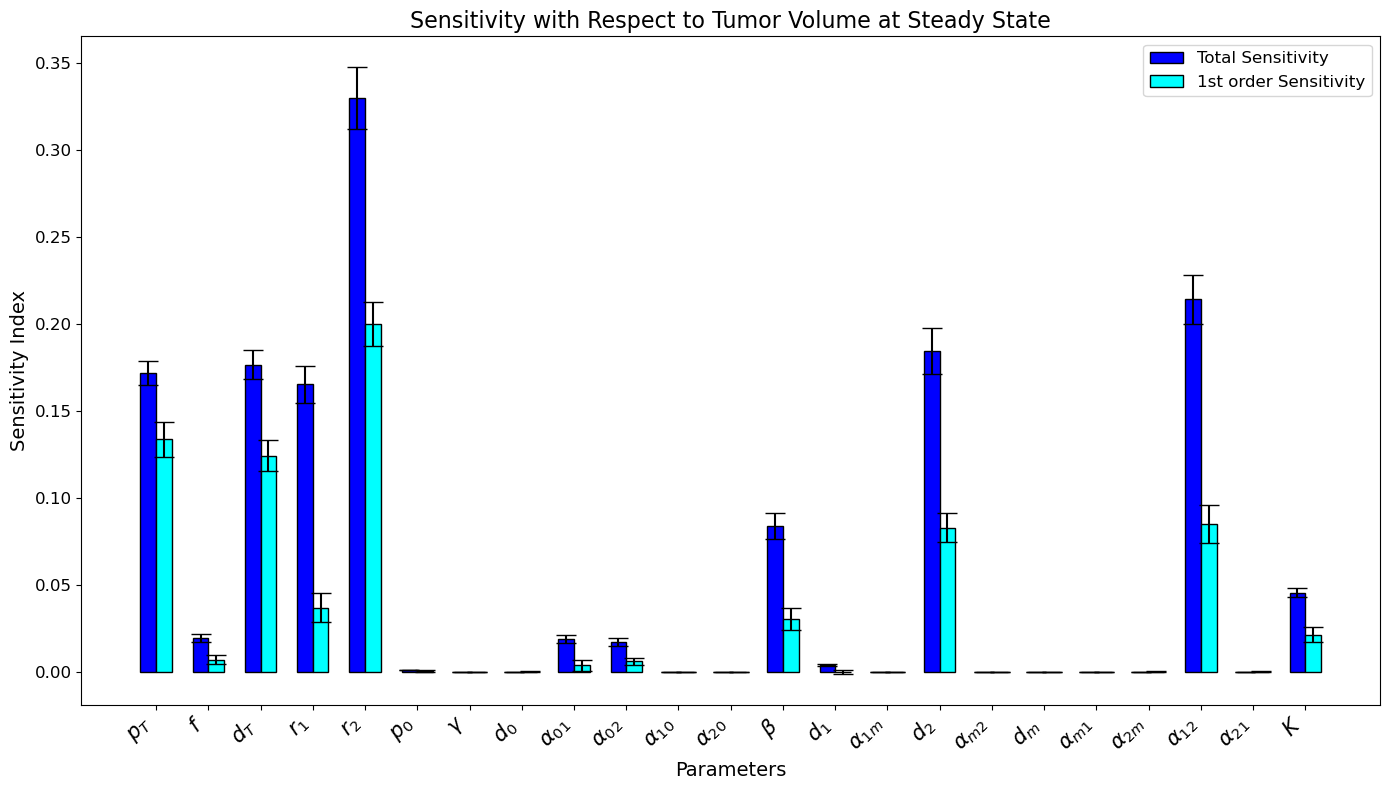

In [11]:
# these are fixed across cases
pT = .023 # rescaled
p0 = .7
K = .5
f = .5
g = 1
r1 = 10 # rescaled
r2 = 10 # rescaled
dT = .01
d0 = .1
d1 = .1
d2 = .1
dm = .1

alpha10 = .0001
alpha12 = .01
alpha21 = .001
alpha2m = .001
alpham1 = .001
alpham2 = .01

b = 2

# case 9 values for alphas from Table 4 in Overleaf (these vary by cases)

alpha02 = .1
alpha1m = .001
alpha01 = 1
alpha20 = .0001
alpha12 = .1


# Define parameter problem and bounds
problem = {
    'num_vars': 23, # remove h so there are 23 parameters
    'names': ['pT', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21', 'K'],
    'bounds': [[0.5*pT, 1.5*pT],    
               [0.5*f, 1.5*f], 
               [0.5*dT, 1.5*dT],
               [0.5*r1, 1.5*r1],
               [0.5*r2, 1.5*r2],
               [0.5*p0, 1.5*p0],
               [0.5*g, 1.5*g],
               [0.5*d0, 1.5*d0],
               [0.5*alpha01, 1.5*alpha01],
               [0.5*alpha02, 1.5*alpha02],
               [0.5*alpha10, 1.5*alpha10],
               [0.5*alpha20, 1.5*alpha20],
               [0.5*b, 1.5*b],
               [0.5*d1, 1.5*d1],
               [0.5*alpha1m, 1.5*alpha1m],
               [0.5*d2, 1.5*d2],
               [0.5*alpham2, 1.5*alpham2],
               [0.5*dm, 1.5*dm],
               [0.5*alpham1, 1.5*alpham1], 
               [0.5*alpha2m, 1.5*alpha2m], 
               [0.5*alpha12, 1.5*alpha12], 
               [0.5*alpha21, 1.5*alpha21], 
               [0.5*K, 1.5*K]] 
}

# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 16384, calc_second_order=True) 

Y = np.zeros([param_values.shape[0]]) # Array to hold outcome of interest 

start = time.time() # Time process

for i in range(param_values.shape[0]): # Loop through each row of parameter array
    params = tuple(param_values[i]) # Create a tuple of parameters

    # Solve the system of differential equations with parameters
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')
    Y[i] = soln.y[0, -1]  # Outcome of interest is tumor volume at steady state

end = time.time()
print(end-start)

# Perform sensitivity analysis
Si = sobol.analyze(problem, Y)

# Extract and prepare data for plotting
S1_values = Si['S1'].tolist()
ST_values = Si['ST'].tolist()
STconf_values = Si['ST_conf'].tolist()
S1conf_values = Si['S1_conf'].tolist()

# Plotting
barWidth = 0.3
r1 = np.arange(len(ST_values))
r2 = [x + barWidth for x in r1]

f = plt.figure(figsize=(14, 8))  # Increase figure size if needed

# Create bars for ST and S1
plt.bar(r1, ST_values, width=barWidth, color='blue', edgecolor='black', yerr=STconf_values, capsize=7, label='Total Sensitivity')
plt.bar(r2, S1_values, width=barWidth, color='cyan', edgecolor='black', yerr=S1conf_values, capsize=7, label='1st order Sensitivity')

# Configure plot with LaTeX labels and larger fonts
plt.xticks([r + barWidth/2 for r in range(len(ST_values))],
           [r'$p_T$', r'$f$', r'$d_T$', r'$r_1$', r'$r_2$', r'$p_0$', r'$\gamma$', r'$d_0$', 
            r'$\alpha_{01}$', r'$\alpha_{02}$', r'$\alpha_{10}$', r'$\alpha_{20}$', r'$\beta$', r'$d_1$',
            r'$\alpha_{1m}$', r'$d_2$', r'$\alpha_{m2}$', r'$d_m$', r'$\alpha_{m1}$', r'$\alpha_{2m}$',
            r'$\alpha_{12}$', r'$\alpha_{21}$', r'$K$'], 
           rotation=45, ha='right', fontsize=15) # control font size here

plt.ylabel(r'Sensitivity Index', fontsize=14)
plt.xlabel('Parameters', fontsize=14)
plt.title(r'Sensitivity with Respect to Tumor Volume at Steady State', fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust layout to avoid clipping
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()

# Save and show the plot
f.savefig("GSA-Case9-TumorVolume-2025May.pdf", bbox_inches='tight', dpi=300)
plt.show()
